         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

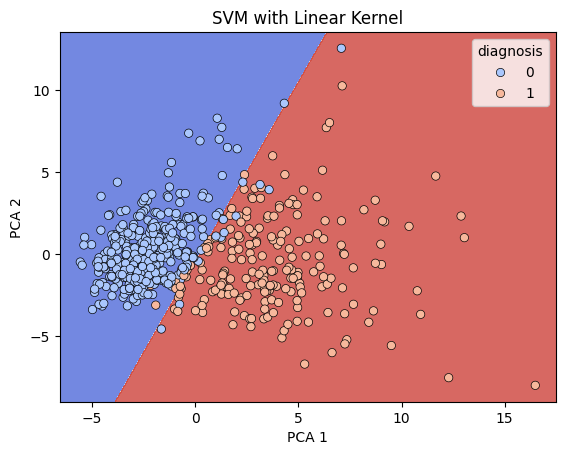

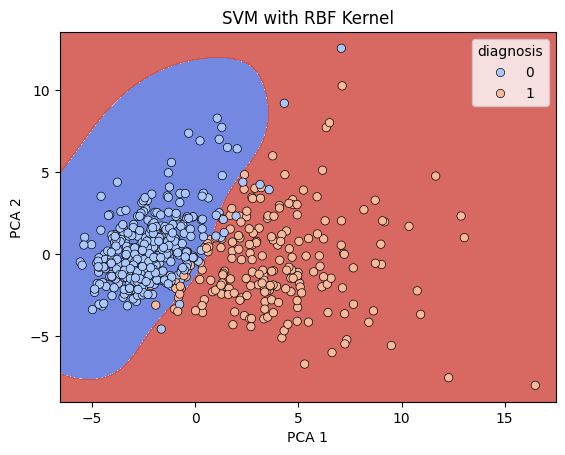

In [1]:
# Install necessary libraries (only for Colab users)
# !pip install scikit-learn matplotlib pandas seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load dataset
df = pd.read_csv("/content/breast-cancer.csv")

# Explore data
print(df.head())
print(df.info())

# Drop any unnamed or unnecessary columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Handle missing values if any
df = df.dropna()

# Encode target if it's categorical
if df['diagnosis'].dtype == 'object':
    df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})  # Malignant = 1, Benign = 0

# Split features and labels
X = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Train SVM with linear kernel
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
print("Linear Kernel SVM Accuracy:", accuracy_score(y_test, y_pred_linear))

# Train SVM with RBF kernel
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
print("RBF Kernel SVM Accuracy:", accuracy_score(y_test, y_pred_rbf))

# Cross-validation scores
cv_scores_linear = cross_val_score(svm_linear, X_pca, y, cv=5)
cv_scores_rbf = cross_val_score(svm_rbf, X_pca, y, cv=5)
print("CV Score (Linear):", np.mean(cv_scores_linear))
print("CV Score (RBF):", np.mean(cv_scores_rbf))

# Hyperparameter tuning for RBF SVM
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid.fit(X_pca, y)
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# Visualization function
def plot_decision_boundary(model, X, y, title):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', edgecolor='k')
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

# Plot decision boundaries
plot_decision_boundary(svm_linear, X_pca, y, "SVM with Linear Kernel")
plot_decision_boundary(svm_rbf, X_pca, y, "SVM with RBF Kernel")
